In [1]:
# Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.models import Model
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize


/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Directory structure
TRAIN_DIR = "PROCESSED_DATA/TRAINING_DATA/TRAINING_AUGMENTED_DATA"
VALID_DIR = "PROCESSED_DATA/VALIDATION_DATA/"
TEST_DIR = "PROCESSED_DATA/TEST_DATA/"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load Data
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_generator = datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)


Found 6642 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Found 220 images belonging to 11 classes.


In [3]:
# Build a CNN model
def build_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    return model

# Build a Transfer Learning Model
def build_transfer_learning(model_name):
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'EfficientNet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError("Invalid model name. Choose from 'ResNet50', 'EfficientNet', or 'VGG16'")
    
    base_model.trainable = False  # Freeze the base model layers
    
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(train_generator.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)
    return model


#### Standard CNN without transfer learning

In [4]:
# Select the model to train
use_transfer_learning = False  # Change to False for a standard CNN
transfer_model_name = 'ResNet50'  # Options: 'ResNet50', 'EfficientNet', 'VGG16'

if use_transfer_learning:
    model = build_transfer_learning(transfer_model_name)
else:
    model = build_cnn()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
training_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Sound that plays after training model is finished
repeat_times = 3  
if os.name == 'posix':  # For macOS and Linux
    for _ in range(repeat_times):
        os.system('afplay /System/Library/Sounds/Glass.aiff')  # macOS
        # Linux users: os.system('aplay /path/to/sound.wav')
        


Epoch 1/10


/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


208/208 ━━━━━━━━━━━━━━━━━━━━ 67s 319ms/step - accuracy: 0.1074 - loss: 2.4309 - val_accuracy: 0.2386 - val_loss: 2.2790
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 68s 328ms/step - accuracy: 0.2108 - loss: 2.2251 - val_accuracy: 0.3091 - val_loss: 2.1239
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 68s 327ms/step - accuracy: 0.2787 - loss: 2.0746 - val_accuracy: 0.3568 - val_loss: 2.0676
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 68s 326ms/step - accuracy: 0.3395 - loss: 1.9361 - val_accuracy: 0.3864 - val_loss: 1.9912
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 67s 322ms/step - accuracy: 0.3645 - loss: 1.8278 - val_accuracy: 0.3932 - val_loss: 1.9380
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 67s 322ms/step - accuracy: 0.4197 - loss: 1.7044 - val_accuracy: 0.4136 - val_loss: 1.8990
Epoch 7/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 67s 322ms/step - accuracy: 0.4607 - loss: 1.5767 - val_accuracy: 0.4205 - val_loss: 1.8803
Epoch 8/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 67s 322ms/step - accuracy: 0.5043 - loss: 1.4761 - val

In [5]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model
model.save("pest_classifier_cnn.h5")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3533 - loss: 2.0864


Test Accuracy: 0.3636


#### Use transfer leaning: EfficientNet

In [ ]:
# Select the model to train
use_transfer_learning = True  # Change to False for a standard CNN
transfer_model_name = 'EfficientNet'  # Options: 'ResNet50', 'EfficientNet', 'VGG16'

if use_transfer_learning:
    model = build_transfer_learning(transfer_model_name)
else:
    model = build_cnn()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
training_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Sound that plays after training model is finished
repeat_times = 3  
if os.name == 'posix':  # For macOS and Linux
    for _ in range(repeat_times):
        os.system('afplay /System/Library/Sounds/Glass.aiff')  # macOS
        # Linux users: os.system('aplay /path/to/sound.wav')

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model
model.save("pest_classifier_cnn_efficientnet.h5")


### Evaluation Metrics

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Classification Report:


,precision,recall,f1-score,support
adult rice weevil,0.240000,0.300000,0.266667,20.000000
american house spider,0.470588,0.400000,0.432432,20.000000
bedbug,0.357143,0.250000,0.294118,20.000000
brown stink bug,0.375000,0.300000,0.333333,20.000000
carpenter ant,0.562500,0.450000,0.500000,20.000000
cellar spider,0.279070,0.600000,0.380952,20.000000
flea,0.230769,0.150000,0.181818,20.000000
house centipede,0.461538,0.300000,0.363636,20.000000
silverfish,0.458333,0.550000,0.500000,20.000000
subterranean termite,0.200000,0.200000,0.200000,20.000000


<Figure size 800x600 with 0 Axes>

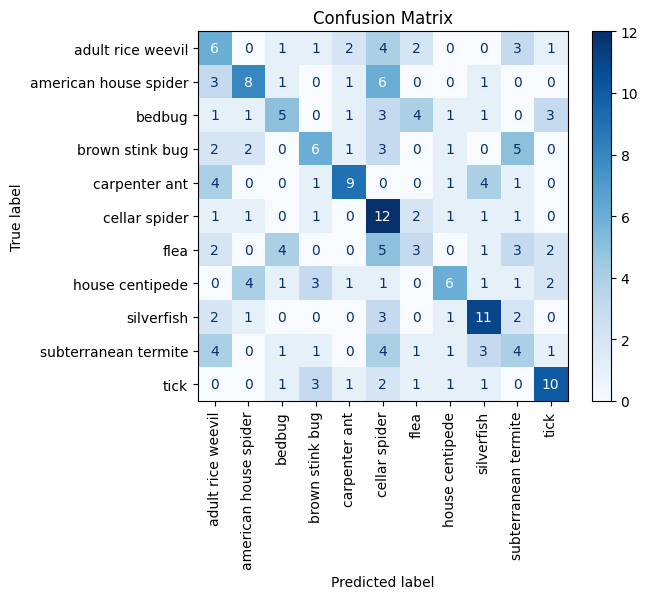

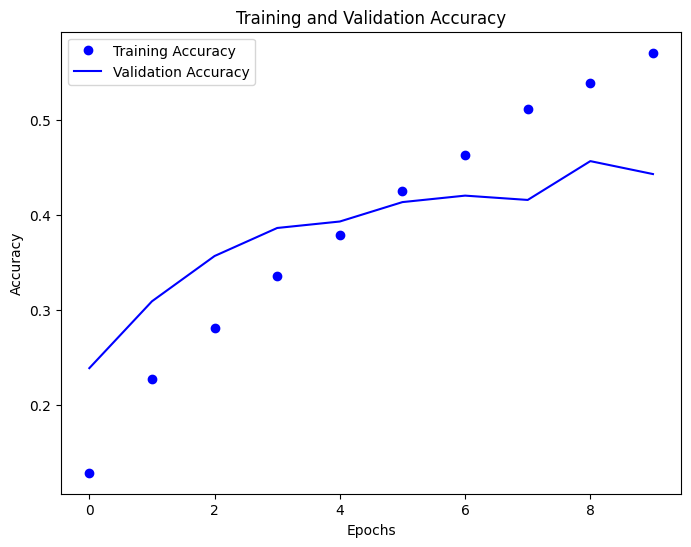

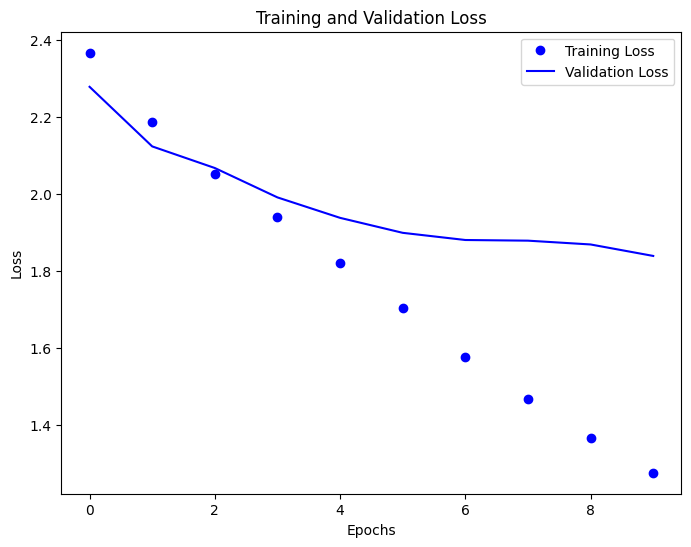

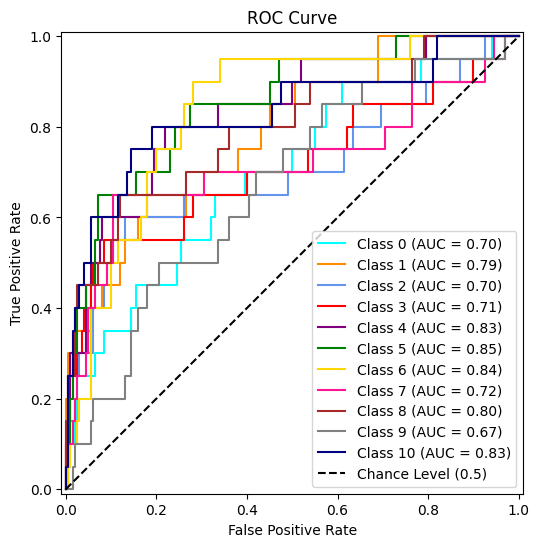

Macro-averaged One-vs-One ROC AUC score: 0.77
Accuracy: 0.364
Precision: 0.378
Recall: 0.364
F1 Score: 0.361


In [8]:
# ------- FUNCTIONS -------

def create_classification_report(y_true, y_pred, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred: predicted class labels
        class_indices: mapping of class labels to class names.

    Function:
        generates a classification report including precision, recall, F1-score, and accuracy for each class
        outputs the report as a DataFrame for further analysis

    Returns:
        classification report as a dataframe
    '''
    report = classification_report(y_true, y_pred, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:")
    display(report_df)
    return report_df

def plot_confusion_matrix(y_true, y_pred, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred: predicted class labels
        class_indices: Mapping of class labels to class names

    Function:
        Plots a confusion matrix

    '''
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(cmap=plt.cm.Blues, colorbar=True)
    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')
    plt.show()


def plot_loss_curves(training_history):
    '''
    Params:
        training_history: object from model.fit() training history containing metrics accuracy and loss

    Function:
        plots training and validation accuracy and loss curves to evaluate model performance over epochs

    '''
    accuracy = training_history.history.get('accuracy', [])
    val_accuracy = training_history.history.get('val_accuracy', [])
    loss = training_history.history.get('loss', [])
    val_loss = training_history.history.get('val_loss', [])
    epochs = range(len(accuracy))

    # Plot training validation accuracy curve
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_roc_curve(y_true, y_pred_probs, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred_probs: predicted probabilities for each class
        class_indices: mapping of class labels to class names

    Function:
        plots the receiver operating characteristic (ROC) curve for each class and calculates the macro-averaged
        one vs one (OvO) ROC AUC score

    Returns:
        macro averaged one vs one ROC AUC score
    '''

    # ROC AUC reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # ROC curve and AUC for multi-class classification
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_indices))))
    n_classes = y_true_bin.shape[1]

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "purple", "green", "gold", "deeppink", "brown", "gray", "navy"])

    for i, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_true_bin[:, i],
            y_pred_probs[:, i],
            name=f"Class {i}",
            color=color,
            ax=ax
        )

    # Macro average reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # Macro average ROC AUC score using OvO strategy
    macro_roc_auc_ovo = roc_auc_score(y_true, 
                                      y_pred_probs, 
                                      multi_class="ovo", 
                                      average="macro")
    
    # ROC AUC plot reference: https://scikit-learn.org/1.1/auto_examples/model_selection/plot_roc.html
    # Plot ROC AUC curve
    ax.plot([0, 1], [0, 1], "k--", label="Chance Level (0.5)")
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC Curve",
    )
    ax.legend(loc="lower right")
    plt.show()
    print(f"Macro-averaged One-vs-One ROC AUC score: {macro_roc_auc_ovo:.2f}")
    return macro_roc_auc_ovo

def evaluation_metrics(model, generator, training_history):
    '''
    Params:
        model: trained model
        generator: data generator for the evaluation set
        training_history: object from model.fit() training history containing metrics accuracy and loss

    Function:
        combines evaluation metrics (classification report, confusion matrix, training curves, and ROC curve)
        outputs key metrics: accuracy, precision, recall, and F1-score

    Returns: 
        dictionary containing:
            accuracy: model accuracy on the evaluation data
            precision: macro averaged precision score
            recall: macro averaged recall score
            f1_score: macro averaged F1 score
            classification_report_df: classification report as a dataframe

    Outputs:
        confusion matrix plot
        loss plots
        macro average ROC curve plot
        macro averaged one vs one ROC AUC score
    '''
    y_true = generator.classes
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    class_indices = generator.class_indices

    # Classification report
    report_df = create_classification_report(y_true, y_pred, class_indices)

    # Confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_indices)
    
    # Loss curves
    plot_loss_curves(training_history)

    # Macro average ROC AUC score
    macro_roc_auc_ovo = plot_roc_curve(y_true, y_pred_probs, class_indices)

    # Get key metrics
    accuracy = round(report_df.loc["accuracy", "precision"], 3)
    precision = round(report_df.loc["macro avg", "precision"], 3)
    recall = round(report_df.loc["macro avg", "recall"], 3)
    f1_score = round(report_df.loc["macro avg", "f1-score"], 3)

    # Print key metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "classification_report_df": report_df
    }

# Run evaluation metrics on cnn model (w/o transfer learning)
cnn_model_metrics = evaluation_metrics(model, test_generator, training_history)